In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(q, conn)
    
def run_command(q):
    with sqlite3.connect("chinook.db") as conn:
        conn.execute(q)
        
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(q)

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [3]:
# Find the genre that is sold best in USA
# Firstly find the table that contains the info of the invoice_line sold in USA and then group by genre with counting
genre_best_seller = '''
WITH tracks_sold_USA AS
    (
     SELECT il.* FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
     WHERE c.country = "USA"
     )
     
SELECT
    g.name genre,
    COUNT(tsu.invoice_line_id) tracks_sold,
    CAST(COUNT(tsu.invoice_line_id) AS FLOAT) / (SELECT CAST(COUNT(*) AS FLOAT) FROM tracks_sold_USA) tracks_sold_pct
FROM tracks_sold_USA tsu
INNER JOIN track t ON t.track_id = tsu.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC;
'''

run_query(genre_best_seller)

,genre,tracks_sold,tracks_sold_pct
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


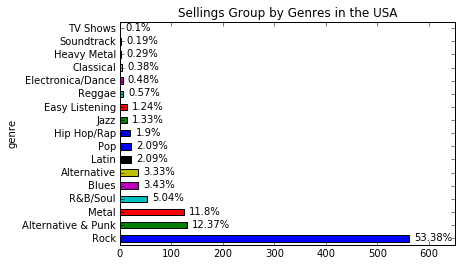

In [4]:
genres_sold_USA = run_query(genre_best_seller)

# Set the genre name as the index for visualization
genres_sold_USA.set_index("genre", inplace=True, drop=True)

genres_sold_USA["tracks_sold"].plot.barh(
    title="Sellings Group by Genres in the USA",
    xlim=(0, 650),
)

# Add in the percentages
for i, genre in enumerate(list(genres_sold_USA.index)):
    score = genres_sold_USA.loc[genre, "tracks_sold"]
    label = (genres_sold_USA.loc[genre, "tracks_sold_pct"] * 100
            ).astype(float).round(2).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

According to the sales data in the USA, the three albums should be added to the store are from the Regal in 

In [5]:
# Find the total dollar amount of sales assigned to each sales support agent
# Firstly find the total purchase of each customer and then sum up to find the total sales of each agent
total_sales_employee = '''
WITH customer_purchase AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         sum(i.total) total
     FROM invoice i
     INNER JOIN customer c ON c.customer_id = i.customer_id
     GROUP BY 1
     )
     
SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    sum(cp.total) sales_total
FROM customer_purchase cp
INNER JOIN employee e ON e.employee_id = cp.support_rep_id
GROUP BY 1;
'''

run_query(total_sales_employee)

,employee,hire_date,sales_total
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


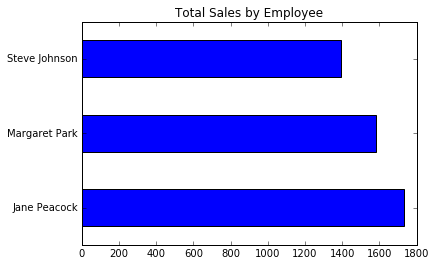

In [6]:
employee_sales = run_query(total_sales_employee)

employee_sales.set_index("employee", drop=True, inplace=True)

employee_sales.plot.barh(
    legend = False,
    title='Total Sales by Employee',
)

plt.ylabel('')
plt.show()

Although there are differences between these employees, but these are mostly determined by the length they worked here.

In [7]:
# Find the sales data for different countries
# Firstly create the table for different countries including 'Other' with invoice_line info
# Calculate the results required and sort in the desired order by creating a new numeric column
sales_country = '''
WITH country_summary AS
    (
     SELECT
         CASE
             WHEN (
                   SELECT COUNT(*)
                   FROM customer
                   where country = c.country
                   ) = 1 THEN "Other"
             ELSE c.country
         END AS country,
         c.customer_id,
         il.*
     FROM customer c
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
     ),
     country_sale_summary AS
    (
     SELECT
         country,
         COUNT(distinct customer_id) num_cust,
         SUM(unit_price) total_sales,
         CAST(SUM(unit_price) AS FLOAT) / COUNT(distinct customer_id) sales_per_cust,
         CAST(SUM(unit_price) AS FLOAT) / COUNT(distinct invoice_id) sales_per_order,
         CASE
             WHEN country = "Other" THEN 1
             ELSE 0
         END AS sort
     FROM country_summary
     GROUP BY 1
     ORDER BY sort ASC, 3 DESC
     )
     
SELECT
    country,
    num_cust,
    total_sales,
    sales_per_cust,
    sales_per_order
FROM country_sale_summary;
'''

run_query(sales_country)

,country,num_cust,total_sales,sales_per_cust,sales_per_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


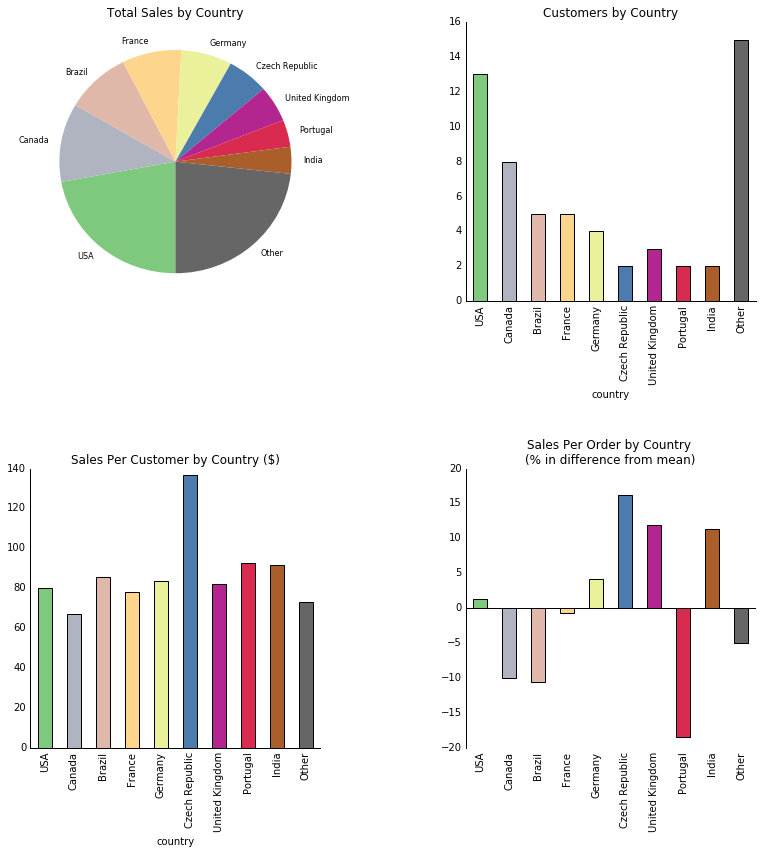

In [8]:
import numpy as np
counrty_sales = run_query(sales_country)
counrty_sales.set_index("country", drop=True, inplace=True)

# Set the uniform color map for different countries
cm = [plt.cm.Accent(i) for i in np.linspace(0, 1, counrty_sales.shape[0])]

fig, axes = plt.subplots(2, 2, figsize=(13, 13))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.6, wspace=.5)

# Pie chart for total sales to see the percentages
counrty_sales["total_sales"].plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title="Total Sales by Country",
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}    
)
ax1.set_ylabel("")

# Bar chart for the numbers of customers
counrty_sales["num_cust"].plot.bar(
    ax=ax2,
    color = cm,
    title="Customers by Country"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Bar chart for the average sales per customer
counrty_sales["sales_per_cust"].plot.bar(
    ax=ax3,
    color = cm,
    title = "Sales Per Customer by Country ($)"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

# Bar chart for the average sales per order
spo = counrty_sales["sales_per_order"].copy()
spo.index.name = ''
difference_from_avg = spo * 100 / spo.mean() - 100
difference_from_avg.plot.bar(
    ax=ax4,
    color = cm,
    title="Sales Per Order by Country \n(% in difference from mean)"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.axhline(0, color='k')
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines["bottom"].set_visible(False)

plt.show()

Based on these data, three countries are seelcted as with the potential for growth, including Czech Republic, United Kingdom, and India, since they have high sales per customer and sales per order, but low numbers of customers and total sales.

In [9]:
albums_tracks = '''
WITH invoice_with_track AS
    (
     SELECT 
         il.invoice_id invoice_id,
         MAX(il.track_id) track_id
     FROM invoice_line il
     GROUP BY 1
    ),
     albums_tracks_categorize AS
    (
     SELECT
         iwt.*,
         CASE
             WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = iwt.track_id
                                      )
                  EXCEPT
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = iwt.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = iwt.invoice_id
                  
                  EXCEPT
                  
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = iwt.track_id
                                      )
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "whole_album_purchased"
     FROM invoice_with_track iwt
    )
    
SELECT
    whole_album_purchased,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) percentage
FROM albums_tracks_categorize
GROUP BY 1;
'''
run_query(albums_tracks)

,whole_album_purchased,number_of_invoices,percentage
0,no,500,0.814332
1,yes,114,0.185668


In [14]:
test = '''
WITH invoice_with_track AS
    (
     SELECT 
         il.invoice_id invoice_id,
         MAX(il.track_id) track_id
     FROM invoice_line il
     GROUP BY 1
    )
    
     SELECT
         iwt.*,
         CASE
             WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = iwt.track_id
                                      )
                  EXCEPT
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = iwt.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = iwt.invoice_id
                  
                  EXCEPT
                  
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = iwt.track_id
                                      )
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "whole_album_purchased"
     FROM invoice_with_track iwt
                                      
'''

run_query(test)

,invoice_id,track_id,whole_album_purchased
0,1,1173,yes
1,2,3476,no
2,3,2646,no
3,4,3448,no
4,5,2002,yes
5,6,1045,no
6,7,3477,no
7,8,2946,no
8,9,3456,no
9,10,3290,no
